# Решающие деревья. Практика

В этом задании будем решать задачу классификации клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора (оттоковый клиент) в ближайшее время или нет.

В ноутбуке будем использовать несколько моделей, в том числе SVM, поэтому установим библиотеку для быстрого обучения SVM.

## Импорт библиотек и загрузка данных

In [1]:
# убедимся, что версия python < 3.10
# !python --version

In [2]:
# %%capture
# !python -m pip install --upgrade pip
# !pip install --upgrade scikit-learn-intelex

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import sys
import os
import site
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [5]:
# зафиксируем константы
RANDOM_STATE = 42

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/telecom_churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Практика

In [7]:
np.random.seed(RANDOM_STATE)

Сделайте первичную обработку данных:

1) Выбросите колонку State

2) Колонки International plan и Voice mail plan закодируйте следующим образом: "Yes" замените на 1, а "No" на 0.

3) Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [8]:
df = df.drop(['State'], axis=1)

In [9]:
for i in ['International plan', 'Voice mail plan']:
    df[i] = df[i].map({'Yes':1, 'No': 0})

In [10]:
df['Churn'] = df['Churn'].map({True : 1, False : 0})

In [11]:
#Проверяем что кодировка прошла корректно
df['International plan'].unique(), df['Voice mail plan'].unique(), df['Churn'].unique()

(array([0, 1], dtype=int64),
 array([1, 0], dtype=int64),
 array([0, 1], dtype=int64))

### Вопрос

Чему равна сумма значений в закодированном столбце International plan?

In [12]:
df['International plan'].sum()

323

Выведите на экран первые строки измененной таблицы, чтобы проверить, что все преобразования сработали.

In [13]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [14]:
X = df.drop('Churn', axis =1)
y = df['Churn']

### Вопрос

Проверьте баланс классов. Является ли выборка сбалансированной?

0    2850
1     483
Name: Churn, dtype: int64


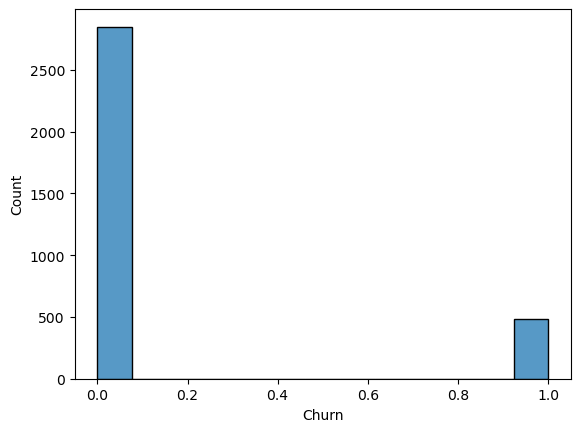

In [15]:
print(y.value_counts())
sns.histplot(y)
plt.show()

**Ответ:** Выборка не сбалансирована.

По кросс-валидации с тремя фолдами и метрикой ROC-AUC (scoring='roc_auc') обучите:

1) Логистическую регрессию

2) Метод опорных векторов (с kernel='linear')

Выведите на экран среднее качество моделей на кросс-валидации.

При объявлении SVC не забудьте указать в гиперпараметрах probability = True (так как метод изначально не предсказывает вероятности классов, а они нам нужны для вычисления ROC-AUC).

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(SVC(kernel='linear', probability=True), X, y, cv=3, scoring='roc_auc', verbose=0).mean()

In [18]:
cross_val_score(LogisticRegression(), X, y, cv=3, scoring='roc_auc', verbose=0).mean()

c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

0.7331175765500708

Теперь обучите решающее дерево с параметрами по умолчанию по кросс-валидации с тремя фолдами и той же метрикой.

ВАЖНО! У решающего дерева для воспроизводимости результатов фиксируйте random_state = RANDOM_STATE

In [19]:
from sklearn.tree import DecisionTreeClassifier

cross_val_score(DecisionTreeClassifier(), X, y, cv=3, scoring='roc_auc', verbose=0).mean()

0.830441320693037

### Вопрос

Какой из трех алгоритмов показал наилучшее качество на кросс-валидации?

Ваша цель - максимально улучшить модели. Для этого:

1) у линейных моделей подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом).

2) у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion - "gini" или "entropy".

Для подбора параметров используйте GridSearchCV с тремя фолдами и метрикой roc-auc или обычные циклы.

Подбор параметров осуществляется только по тренировочным данным!

При подборе гиперпараметров по кросс-валидации для дальнейшей корректной оценки качества модели нужна отдельная выборка. Давайте сразу действовать правильно:

1) сначала разбиваем (как и раньше) данные на тренировочную и тестовую части
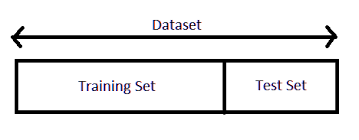

2) затем по тренировочной части при помощи GridSearchCV подбираем оптимальные значения гиперпараметров

3) наконец, делаем предсказание модели с оптимальными гиперпараметрами на тестовых данных и уже по ним оцениваем итоговую метрику.

Сложно, зато правильно!

Первую модель обучим для примера. Дальше вы сами.

In [20]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [21]:
from sklearn.model_selection import GridSearchCV

params = {'C' : np.linspace(0.1, 10.01, 20)}

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')

gs.fit(Xtrain, ytrain)

gs.best_score_, gs.best_estimator_

c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

(0.7115446704866798, LogisticRegression(C=8.966842105263158))

In [22]:
from sklearn.metrics import roc_auc_score

lr = gs.best_estimator_

pred_lr = lr.predict_proba(Xtest)[:,1]
print(roc_auc_score(ytest, pred_lr))

0.786472570603259


In [33]:
params = {'max_depth' : range(1,11, 1),
          'criterion' : ['gini', 'entopy']}

gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=params, cv=3, scoring='roc_auc')
gs.fit(Xtrain, ytrain)

gs.best_estimator_, gs.best_params_

C:\Users\админ\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\админ\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\админ\AppData\Roaming\Python\Python310\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\админ\AppData\Roaming\Python\Python310\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()

(DecisionTreeClassifier(max_depth=6, random_state=42),
 {'criterion': 'gini', 'max_depth': 6})

### Вопрос

Чему равно качество решающего дерева с подобранными гиперпараметрами, посчитанное на тестовой выборке?

Ответ округлите до сотых.

In [34]:
ypred = gs.best_estimator_.predict_proba(Xtest)[:,1]
print(f'Roc-Auc:{roc_auc_score(ytest, ypred)}')

Roc-Auc:0.8555540142471297


Какая модель справилась с решением задачи лучше всего по метрике roc_auc?

DecisionTreeClassifier

Нарисуйте roc-кривую для наилучшей модели.

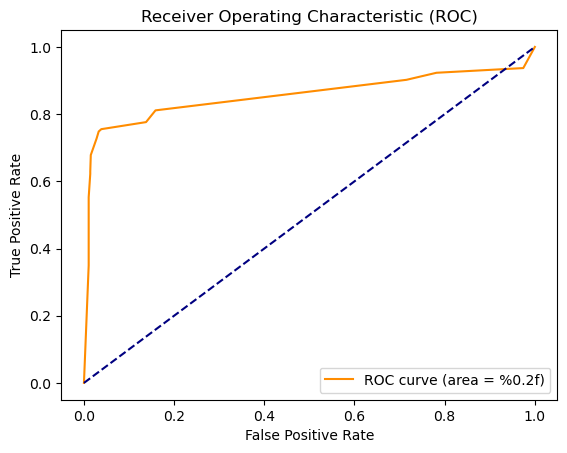

In [36]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(ytest, ypred)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()